In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

# ======
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
from functions.rnn_cryptic_equals import convert_seq2inputs, calculate_output, onehot2seq 

# Functions

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
        
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.000001)


def train(sequence, label ,model ,optimizer ,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict))

    return inps

def predcorr(mods, tests, plot_corr = True):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
    all_dfs1 = pd.concat(dfs1) 
    preds, labs = all_dfs1['pred'], all_dfs1['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    r2_val = r2_score(all_dfs1['pred'],all_dfs1['label'])
    df_fin = all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)
    if plot_corr:
        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_val, 2)) )
             
    return r2_val, df_fin, all_dfs1  

# -----------------
# Generating trials
# -----------------

def generate_primitives(inputs):
    seq = []
    for inp in inputs:
        trial = [inp, '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def generate_trials(op, input_ids, init_values):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat=1))
    for init in init_values:
        for cue in combi_inputcue:
            seq.append([init,
                        *zip(tuple(op), cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def generate_self(op, inputs):
    seq = []
    for inp in inputs:
        trial = generate_trials(op, inp, inp)
        seq += trial
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    inputs2.append(inputs2.pop(0))
    inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [inputs1[i], (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_other_reverse_primitives(op, inputs):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)
    
def heatmap_acc(num_inputs, df, ax):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    map_syms = total_syms[:num_inputs]
    data_accs = np.empty((num_inputs, num_inputs))
    data_accs[:] = np.NaN
    for r, trial in enumerate(df.index):
        i = map_syms.index(eval(trial)[0])
        j = map_syms.index(eval(trial)[2])
        acc = round(df.iloc[r]['acc'], 2)
        data_accs[i,j] = acc
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(num_inputs), labels=map_syms)
    ax.set_yticks(np.arange(num_inputs), labels=map_syms)

    #cmap = mpl.colors.ListedColormap(['yellow', 'orange', 'darkorange','red'])
    from matplotlib import cm
    new_reds = cm.get_cmap('Reds', 10)
    cmap=new_reds
    bounds = list(np.arange(0,1.1,0.1))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data_accs, cmap=cmap, norm=norm)

    # Loop over data dimensions and create text annotations.
    for i in range(num_inputs):
        for j in range(num_inputs):
            if np.isnan(data_accs[i, j]):
                pass
            else:
                text = ax.text(j,i, data_accs[i, j],
                              ha="center", va="center", color="black", fontsize=12)


# RNN setup

In [3]:
## running function

def run_exp(trainseqs_old, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

def run_plot(trainseqs, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    tests = [r['test'] for r in res]

#     plotNNs([losses], [acc_train, acc_test], \
#             ['train', 'test'], colors = ['green', 'orange'], title = '', shift = 0)
    
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:],'test_acc': acc_test[-1,:]}) 
    
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    fully_trained_idx = fully_trained.index
    fully_trained_test_acc = fully_trained['test_acc'].mean() 
    fully_trained_test_acc_std = fully_trained['test_acc'].std()
    
    ft_mods = [mods[i] for i in fully_trained_idx]
    print(len(ft_mods))
    ft_tests = [tests[i] for i in fully_trained_idx]
    if len(ft_mods) > 0:
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, plot_corr = False)
    else:
        r2, dfs, alldfs = 0, 0, 0

    t3 = time.time()
    print('total time: ', (t3-t1)/60)
    print(fully_trained.shape[0], '/', final_accs.shape[0], ' rnns trained to 100% accuracy.\
        \n Mean test acc = ', round(fully_trained_test_acc, 2),  '\n-----------\n')

    return {'res':res, 'r2': r2, 'all_final_accs': final_accs, 'mean_acc_final': fully_trained_test_acc,\
            'all_dfs':alldfs, 'df_trials': dfs, 'acc_std': fully_trained_test_acc_std}

def run_self_other(num_inputs, p=[]):

    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]

    num_other = list(range(0, num_inputs+1))
    num_other.remove(1)

    all_r2s = []
    all_accs = []
    all_reses = []
    all_acc_std = []
    for i in range(len(num_other)):
        n_other = num_other[i]
        print('no. other trials = ', n_other, ';  no. self: ', num_inputs - n_other)
        self_trials = []
        other_trials = []
        if n_other != num_inputs:
            self_trials = generate_self(ops, all_syms[n_other:])
        if n_other != 0:
            other_trials = generate_other(ops, all_syms[:n_other])

        trainseqs = self_trials + other_trials + p
        testseqs = generate_trials(ops, all_syms, all_syms)
        testseqs = [t for t in testseqs if t not in trainseqs]
        print('trainseqs: ', trainseqs)
        print('testseqs: ', testseqs)
        res = run_plot(trainseqs, testseqs, cue_dict)
        all_r2s.append(res['r2'])
        all_accs.append(res['mean_acc_final'])
        all_acc_std.append(res['acc_std'])
        all_reses.append(res)
        
    return all_reses, np.array(all_accs), all_r2s, np.array(all_acc_std)


In [7]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1000
num_sims = 80

# Experiments

Final accuracy against ratio of other/self



## Num inputs = 2

In [8]:
ops = '+'

num_inputs = 2
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(['A','B'])
#p = []
print(p)

{'A': 16, 'B': 9}
[['A', '=', 16], ['B', '=', 9]]


In [ ]:
## 1 trials
num_train = 1

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('+', 'A'), '=', 32], ['A', '=', 16], ['B', '=', 9]]
testseqs:  [['A', ('+', 'B'), '=', 25], ['B', ('+', 'A'), '=', 25], ['B', ('+', 'B'), '=', 18]]


In [ ]:
## 2 trials
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 3
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

In [ ]:
## 3 trials
num_train = 3

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 2
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

## Num inputs = 3

In [513]:
ops = '-'

num_inputs = 3
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms)
#p = []
print(p)

{'A': 7, 'B': 3, 'C': 4}
[['A', '=', 7], ['B', '=', 3], ['C', '=', 4]]


In [ ]:
## 1 trials
num_train = 1

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 3
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', '=', 7], ['B', '=', 3], ['C', '=', 4]]
testseqs:  [['A', ('-', 'B'), '=', 4], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -4], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0]]
run time:  1.7205941955248514
28
total time:  1.722885545094808
28 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.05 
-----------

trainseqs:  [['A', ('-', 'B'), '=', 4], ['A', '=', 7], ['B', '=', 3], ['C', '=', 4]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 3], ['B', ('-', 'A'), '=', -4], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -3], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0]]
run time:  1.6726500312487285
52
total time:  1.6766110142072042
52 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.02 
-----------

trainseqs:  [['A', ('-', 'C'), '=', 3], ['A', '=', 7], ['B', '=', 3],

In [516]:
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

num_cols = 6
fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
for i in range(len(train_trials)):
    trainseqs = list(train_trials[i]) + p
    testseqs = generate_trials(ops, all_syms, all_syms)
    testseqs = [s for s in testseqs if s not in trainseqs]
    print('trainseqs: ', trainseqs)
    print('testseqs: ', testseqs)
    res = run_plot(trainseqs, testseqs, cue_dict)
    df = res['df_trials']
    heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
plt.tight_layout()    

In [518]:
num_train = 3

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

# num_cols = 6
# fig, axs = plt.subplots(math.ceil(len(train_trials)/num_cols), num_cols)
# for i in range(len(train_trials)):
#     trainseqs = list(train_trials[i]) + p
#     testseqs = generate_trials(ops, all_syms, all_syms)
#     testseqs = [s for s in testseqs if s not in trainseqs]
#     print('trainseqs: ', trainseqs)
#     print('testseqs: ', testseqs)
#     res = run_plot(trainseqs, testseqs, cue_dict)
#     df = res['df_trials']
#     heatmap_acc(num_inputs, df, axs[math.floor(i/num_cols), i%num_cols])
# plt.tight_layout()    

In [519]:
len(train_trials)

84

In [440]:
num_train = 2

all_trials = generate_trials(ops, all_syms, all_syms)
trial_combos = list(itertools.combinations(all_trials, r=num_train))
train_trials = [trial for trial in trial_combos]

In [443]:
list(train_trials[0])

[['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', -9]]

In [419]:
trial_combos

[(['A', ('-', 'A'), '=', 0],),
 (['A', ('-', 'B'), '=', -9],),
 (['B', ('-', 'A'), '=', 9],),
 (['B', ('-', 'B'), '=', 0],)]

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', '=', 5], ['B', '=', 14]]
testseqs:  [['A', ('-', 'B'), '=', -9], ['B', ('-', 'A'), '=', 9], ['B', ('-', 'B'), '=', 0]]
run time:  0.20807687044143677
26
total time:  0.21014468669891356
26 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.09 
-----------



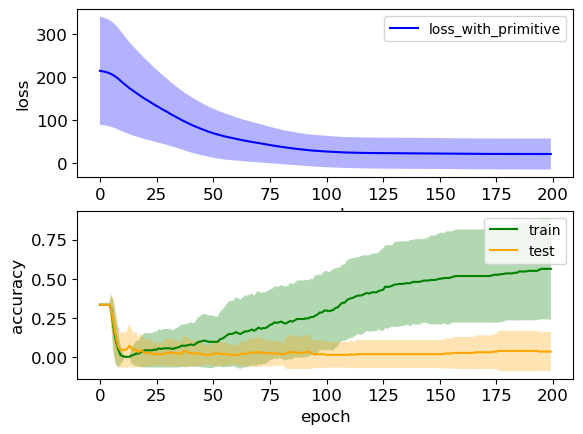

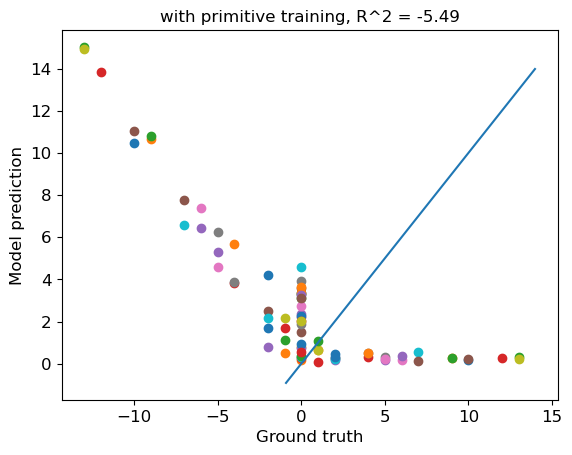

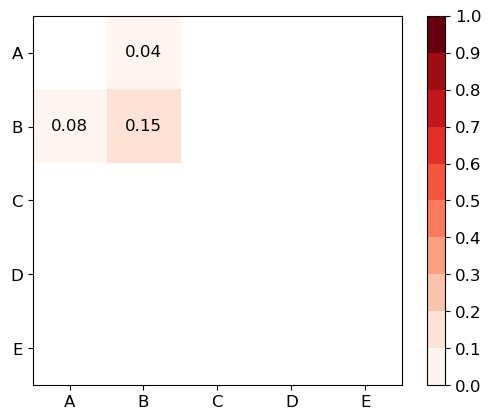

In [396]:
# 1 
epochs = 200
num_train = 3

trainseqs = generate_self(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
df = res['df_trials']
heatmap_acc(num_inputs, df)

In [395]:
res

{'res': [{'cue_dict': {'A': 10, 'B': 11},
   'loss': array([[214.73560211],
          [213.32508055],
          [211.69134715],
          [209.59535402],
          [207.20485476],
          [203.46981442],
          [198.88476193],
          [191.51085347],
          [185.54318142],
          [183.19837475]]),
   'acc': array([[0.33333333, 0.33333333],
          [0.33333333, 0.33333333],
          [0.33333333, 0.33333333],
          [0.33333333, 0.33333333],
          [0.33333333, 0.33333333],
          [0.        , 0.33333333],
          [0.        , 0.33333333],
          [0.        , 0.33333333],
          [0.        , 0.        ],
          [0.        , 0.        ]]),
   'mod': OneStepRNN(
     (rnn): RNN(22, 20, batch_first=True)
     (input2hidden): Linear(in_features=42, out_features=20, bias=True)
     (fc1tooutput): Linear(in_features=20, out_features=1, bias=True)
   ),
   'test': <torch.utils.data.dataloader.DataLoader at 0x7fb5f115f100>},
  {'cue_dict': {'A': 5, 'B': 3},
  

In [367]:
# 2
trainseqs = [generate_other(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res2 = run_plot(trainseqs, testseqs, cue_dict)
res2['df_trials']

trainseqs:  [['B', ('-', 'A'), '=', -5], ['A', '=', 7], ['B', '=', 12]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 5], ['B', ('-', 'B'), '=', 0]]


TypeError: 'tuple' object is not callable

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['A', '=', 3], ['B', '=', 16]]
testseqs:  [['A', ('-', 'B'), '=', -13], ['B', ('-', 'A'), '=', 13]]
run time:  4.633341201146444
51
total time:  4.637153430779775
51 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------



label      pred  acc
trial                                        
['A', '-', 'B', '=']  0.333333  0.867374  0.0
['B', '-', 'A', '='] -0.333333  0.727549  0.0

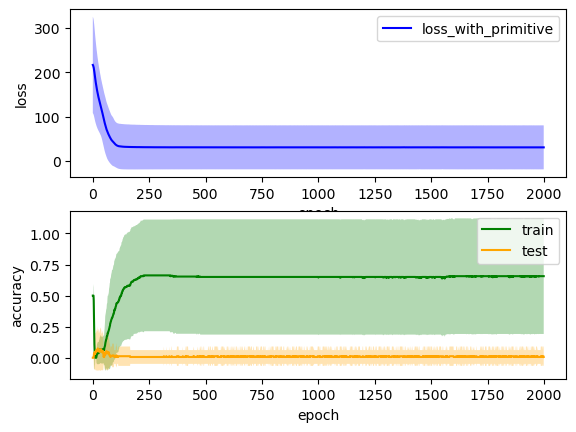

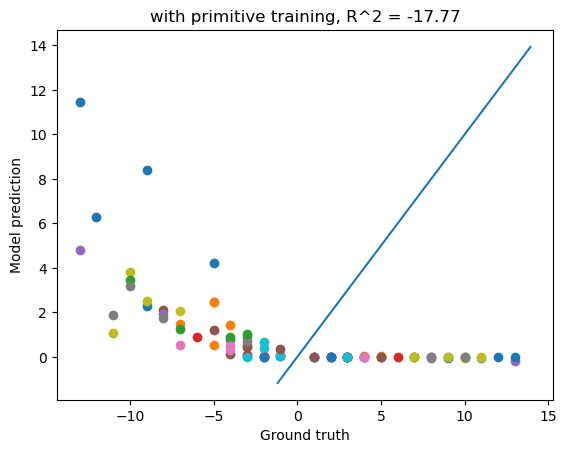

In [12]:
# 3
trainseqs = generate_self(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res3 = run_plot(trainseqs, testseqs, cue_dict)
res3['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', -13], ['B', ('-', 'A'), '=', 13], ['A', '=', 3], ['B', '=', 16]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0]]
run time:  5.250498898824056
70
total time:  5.255383117993673
70 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.09 
-----------



label      pred       acc
trial                                          
['A', '-', 'A', '=']    0.0 -0.256277  0.100000
['B', '-', 'B', '=']    0.0 -0.379681  0.085714

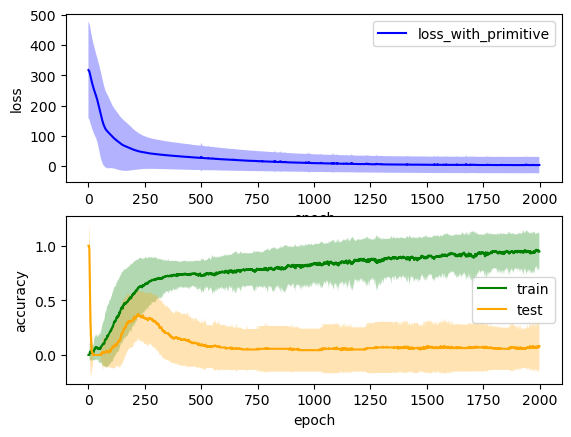

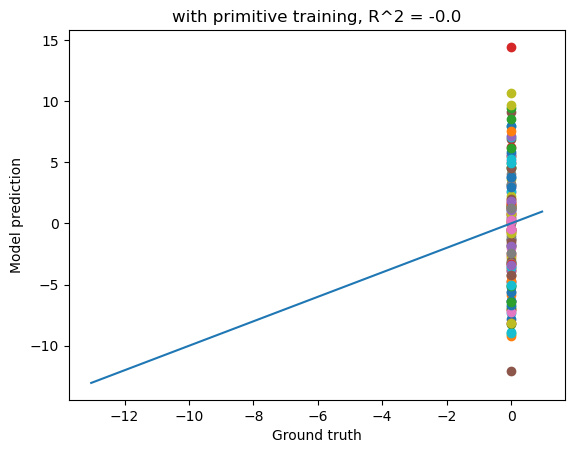

In [13]:
# 4
trainseqs = generate_other(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res4 = run_plot(trainseqs, testseqs, cue_dict)
res4['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', -13], ['B', ('-', 'A'), '=', 13], ['B', ('-', 'B'), '=', 0], ['A', '=', 3], ['B', '=', 16]]
testseqs:  [['A', ('-', 'A'), '=', 0]]
run time:  5.436203761895498
69
total time:  5.4405552983284
69 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.23 
-----------



label      pred       acc
trial                                          
['A', '-', 'A', '=']    0.0 -0.737135  0.231884

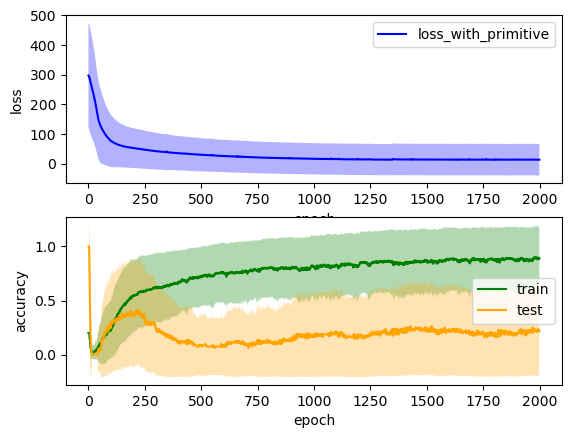

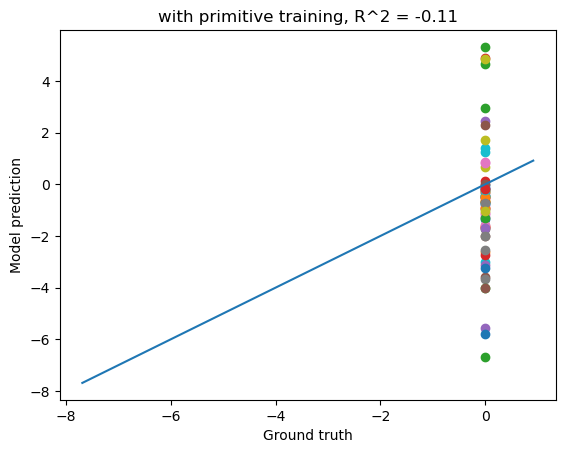

In [14]:
# 5
trainseqs = generate_other(ops, all_syms) + [generate_self(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res5 = run_plot(trainseqs, testseqs, cue_dict)
res5['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'A'), '=', 13], ['A', '=', 3], ['B', '=', 16]]
testseqs:  [['A', ('-', 'B'), '=', -13]]
run time:  5.4543752829233805
43
total time:  5.456855316956838
43 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.14 
-----------



label      pred       acc
trial                                             
['A', '-', 'B', '='] -2.674419  2.896088  0.139535

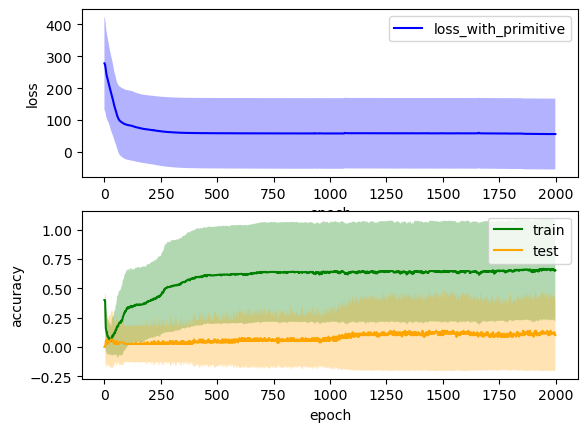

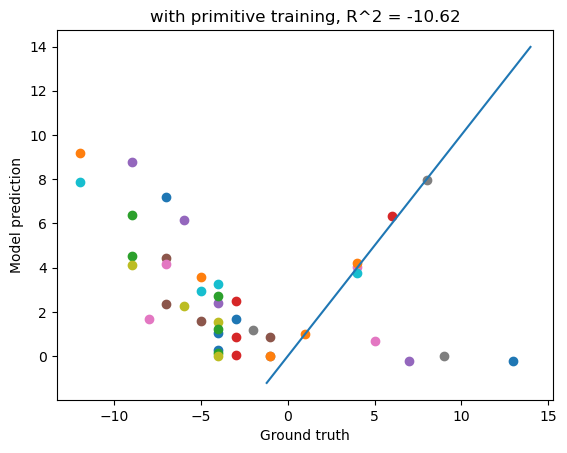

In [15]:
# 6
trainseqs = generate_self(ops, all_syms) + [generate_other(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res6 = run_plot(trainseqs, testseqs, cue_dict)
res6['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', -13], ['A', ('-', 'A'), '=', 0], ['A', '=', 3], ['B', '=', 16]]
testseqs:  [['B', ('-', 'A'), '=', 13], ['B', ('-', 'B'), '=', 0]]
run time:  5.511426778634389
48
total time:  5.51555788119634
48 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.04 
-----------



label      pred       acc
trial                                           
['B', '-', 'B', '=']  0.0000  3.052015  0.062500
['B', '-', 'A', '='] -0.3125  5.092022  0.020833

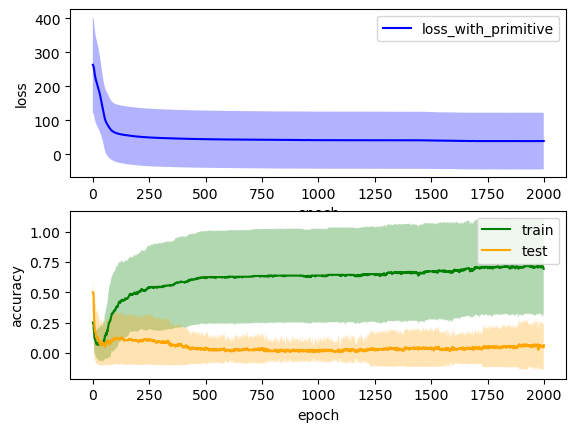

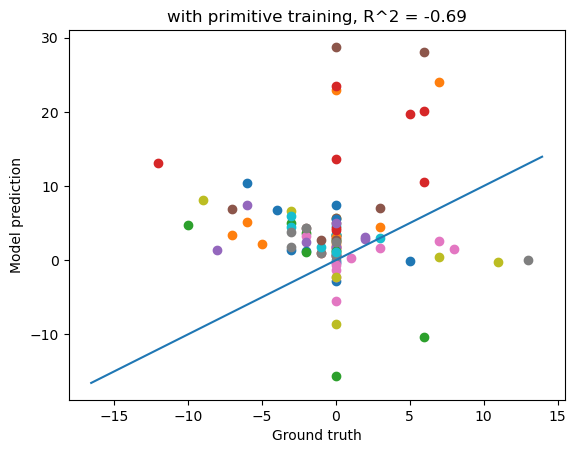

In [16]:
# 7
trainseqs = [generate_other(ops, all_syms)[0]] + [generate_self(ops, all_syms)[0]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res7 = run_plot(trainseqs, testseqs, cue_dict)
res7['df_trials']

# try 3 input symbols

In [41]:
ops = '-'
num_inputs = 3

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
p = generate_primitives(all_syms )
#p = []
print(p)

{'A': 4, 'B': 7, 'C': 12}
[['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]


## 1 trial

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', '=', 17], ['B', '=', 11], ['C', '=', 3]]
testseqs:  [['A', ('-', 'B'), '=', 6], ['A', ('-', 'C'), '=', 14], ['B', ('-', 'A'), '=', -6], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -14], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  6.488462913036346
33
total time:  6.493970314661662
33 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.06 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  3.269414  0.212121
['B', '-', 'B', '=']  0.000000  5.430950  0.090909
['C', '-', 'B', '=']  0.636364  4.935498  0.090909
['A', '-', 'C', '=']  3.636364  0.666263  0.030303
['B', '-', 'C', '='] -0.636364  7.016079  0.030303
['C', '-', 'A', '='] -3.636364  5.375293  0.030303
['A', '-', 'B', '=']  4.272727  1.212892  0.000000
['B', '-', 'A', '='] -4.272727  8.722493  0.000000

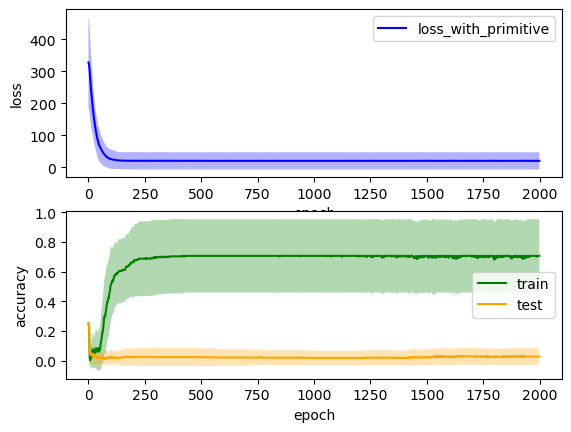

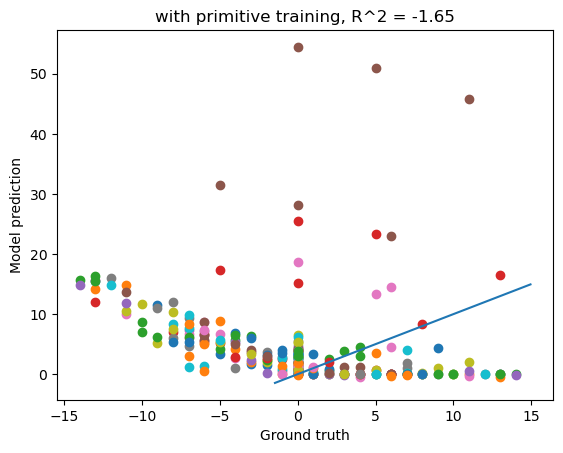

In [36]:
# 1
trainseqs =[ generate_self(ops, all_syms)[0]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

In [45]:
epochs = 10

trainseqs:  [['A', ('-', 'B'), '=', 3], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 2], ['B', ('-', 'A'), '=', -3], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', -1], ['C', ('-', 'A'), '=', -2], ['C', ('-', 'B'), '=', 1], ['C', ('-', 'C'), '=', 0]]
run time:  0.15732413530349731
0
total time:  0.1579583168029785
0 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  nan 
-----------



0

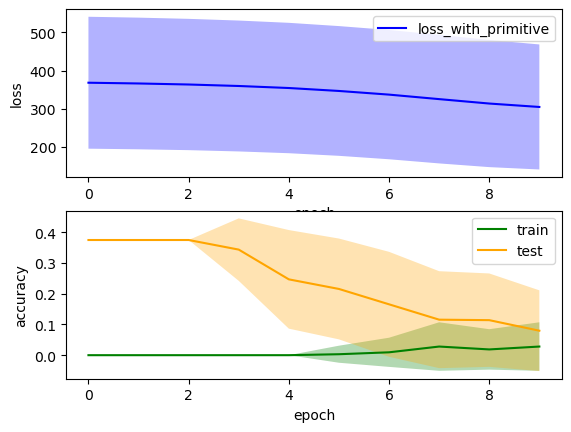

In [46]:
# 2
trainseqs =[generate_other(ops, all_syms)[0]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

## 2 trials

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  3.543110700448354
47
total time:  3.549419383207957
47 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.07 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  1.188234  0.425532
['A', '-', 'C', '=']  1.702128  0.673655  0.021277
['B', '-', 'C', '=']  1.851064  0.720605  0.021277
['A', '-', 'B', '='] -0.148936  1.173944  0.000000
['B', '-', 'A', '=']  0.148936  0.934033  0.000000
['C', '-', 'A', '='] -1.702128  2.607096  0.000000
['C', '-', 'B', '='] -1.851064  2.926959  0.000000

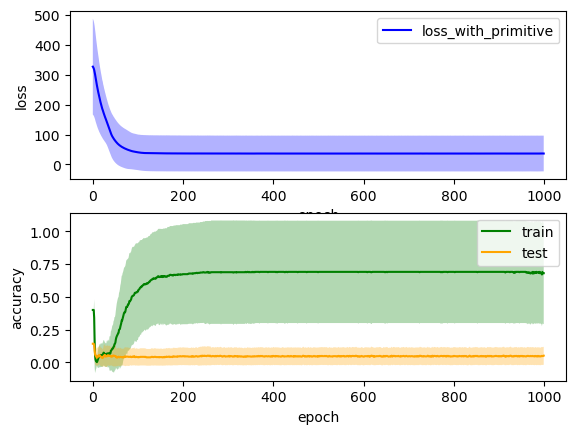

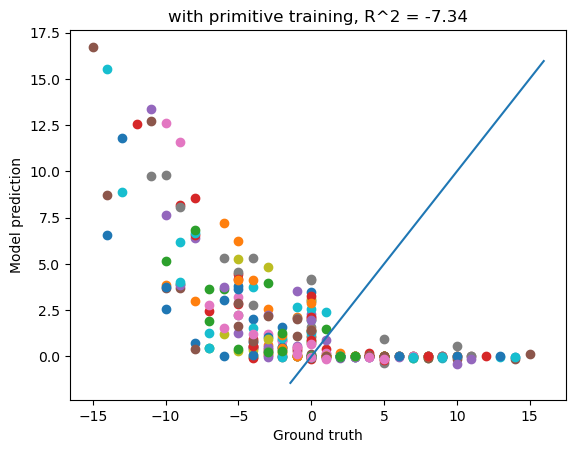

In [52]:
epochs = 1000
# # 2 self
trainseqs =generate_self(ops, all_syms)[:2] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['B', ('-', 'C'), '=', 8], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  3.762516665458679
37
total time:  3.767114317417145
37 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.03 
-----------



label      pred       acc
trial                                             
['A', '-', 'A', '=']  0.000000  3.865042  0.054054
['A', '-', 'C', '=']  4.054054  2.249019  0.054054
['B', '-', 'A', '='] -2.756757  3.683283  0.054054
['B', '-', 'B', '=']  0.000000  1.788728  0.027027
['C', '-', 'A', '='] -4.054054  5.924650  0.000000
['C', '-', 'B', '='] -1.297297  3.357149  0.000000
['C', '-', 'C', '=']  0.000000  1.259298  0.000000

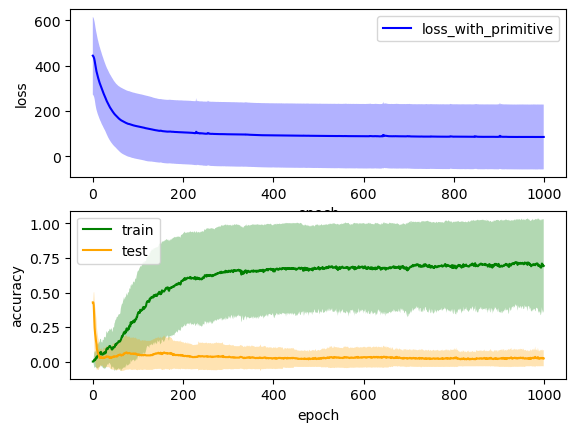

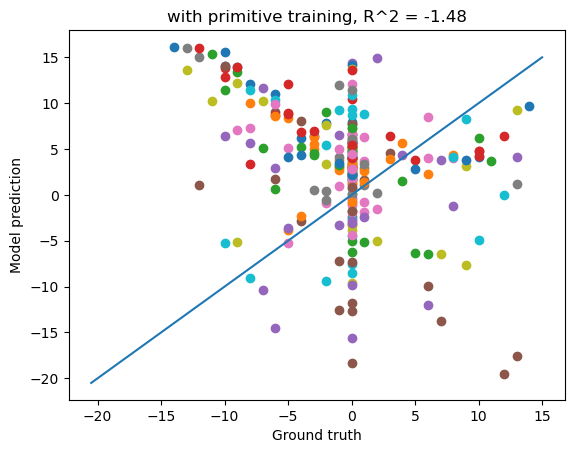

In [55]:
# 2 other
trainseqs =generate_other(ops, all_syms)[:2] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'A'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  3.784638551870982
38
total time:  3.7897053360939026
38 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.06 
-----------



label      pred       acc
trial                                             
['C', '-', 'B', '=']  0.894737  5.205331  0.105263
['C', '-', 'C', '=']  0.000000  4.872107  0.105263
['A', '-', 'C', '=']  1.526316  1.825195  0.052632
['B', '-', 'A', '='] -2.421053  5.526131  0.052632
['B', '-', 'B', '=']  0.000000  3.531185  0.026316
['B', '-', 'C', '='] -0.894737  5.263572  0.026316
['C', '-', 'A', '='] -1.526316  6.344246  0.026316

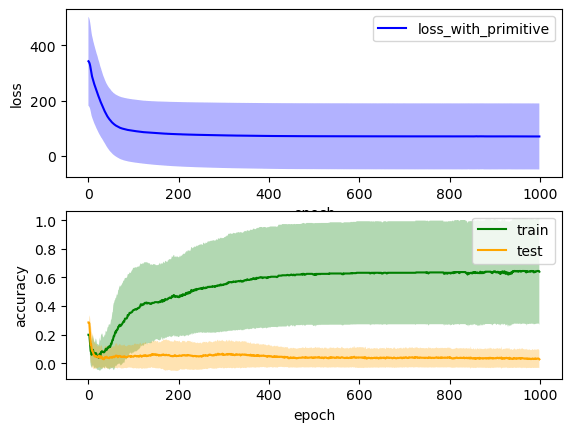

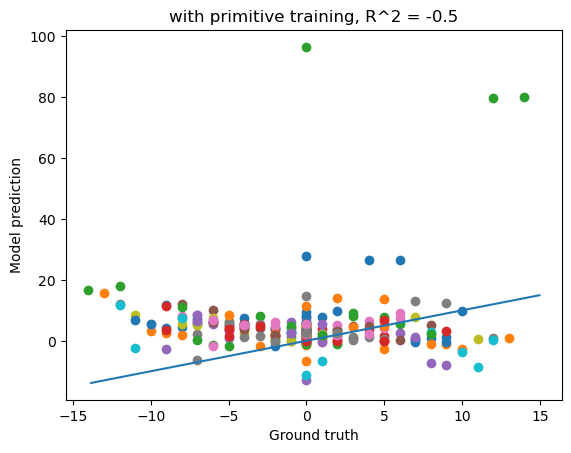

In [63]:
# 0ne of each other
trainseqs =[generate_other(ops, all_syms)[0]] + [generate_self(ops, all_syms)[0]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['B', ('-', 'B'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  3.9577049136161806
33
total time:  3.963783129056295
33 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.06 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  0.622159  0.121212
['C', '-', 'A', '='] -3.969697  2.659542  0.090909
['A', '-', 'A', '=']  0.000000  0.393146  0.060606
['B', '-', 'C', '=']  3.818182  0.336497  0.060606
['C', '-', 'B', '='] -3.818182  2.359293  0.060606
['A', '-', 'C', '=']  3.969697  0.657423  0.000000
['B', '-', 'A', '='] -0.151515  0.521029  0.000000

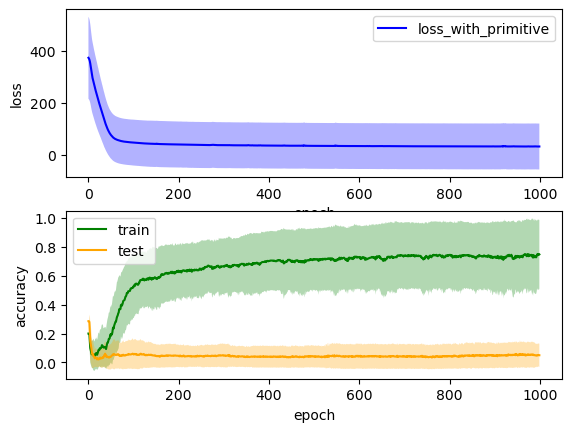

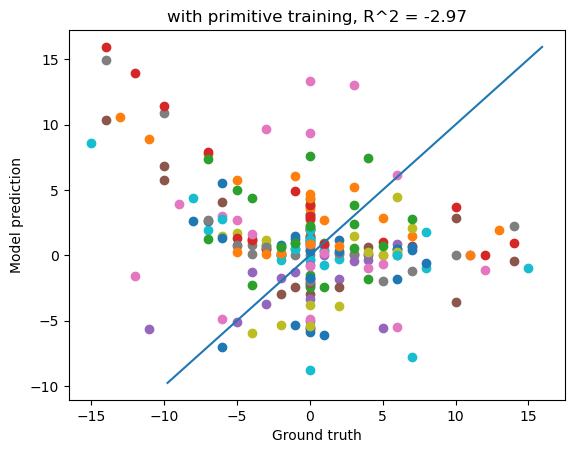

In [62]:
# 0ne of each other
trainseqs =[generate_other(ops, all_syms)[0]] + [generate_self(ops, all_syms)[1]] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.039147321383158
31
total time:  4.044384217262268
31 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.07 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  0.687696  0.225806
['B', '-', 'B', '=']  0.000000  1.381935  0.096774
['B', '-', 'C', '='] -0.580645  2.351921  0.064516
['A', '-', 'C', '=']  2.032258  1.646382  0.032258
['C', '-', 'A', '='] -2.032258  2.942858  0.032258
['C', '-', 'B', '=']  0.580645  2.218052  0.032258
['B', '-', 'A', '='] -2.612903  3.780435  0.000000

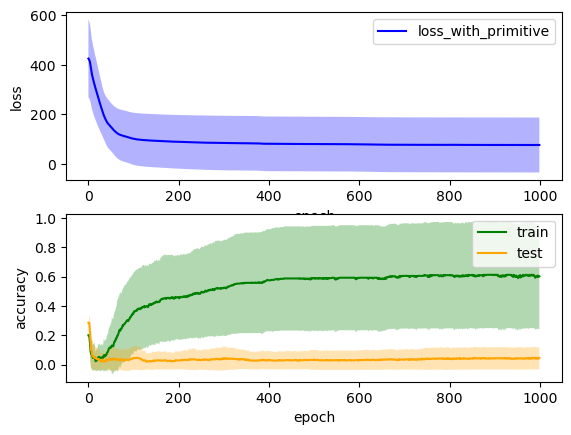

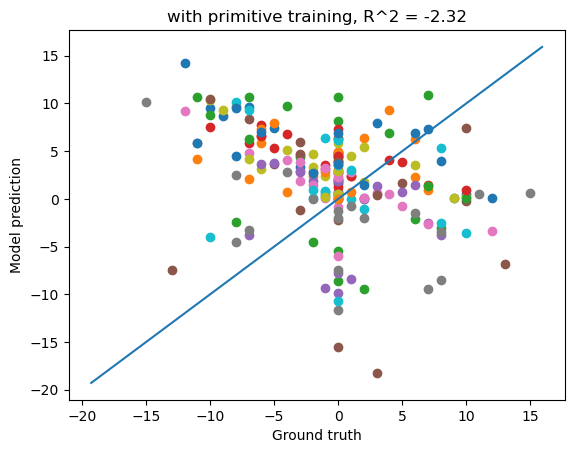

In [92]:
# 0ne of each other
trainseqs =generate_trials(ops, ['A', 'B'], ['A']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', -1], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  3.880017364025116
24
total time:  3.883372664451599
24 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.08 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  2.256276  0.208333
['C', '-', 'A', '='] -3.291667  2.963102  0.125000
['B', '-', 'B', '=']  0.000000  0.950728  0.083333
['A', '-', 'B', '='] -0.333333  0.697209  0.041667
['A', '-', 'C', '=']  3.291667  0.841848  0.041667
['B', '-', 'C', '=']  3.625000  1.147982  0.041667
['C', '-', 'B', '='] -3.625000  4.457630  0.000000

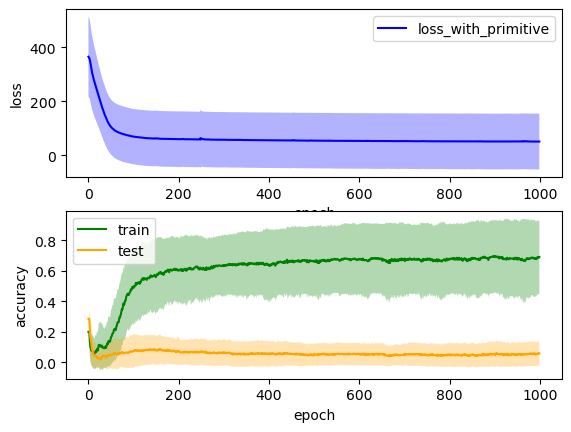

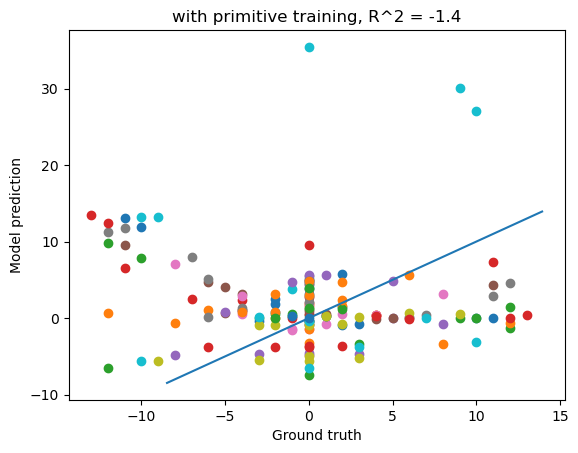

In [96]:
# 0ne of each other
trainseqs = generate_trials(ops, ['A'], ['A','B']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'C'), '=', 8], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  11.442816567420959
42
total time:  11.447845264275868
42 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.04 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  0.984614  0.142857
['B', '-', 'A', '=']  0.190476  1.433571  0.047619
['C', '-', 'A', '='] -1.261905  2.244569  0.047619
['A', '-', 'B', '='] -0.190476  0.864118  0.023810
['A', '-', 'C', '=']  1.261905  0.700098  0.023810
['B', '-', 'B', '=']  0.000000  1.457747  0.023810
['C', '-', 'B', '='] -1.452381  1.886151  0.000000

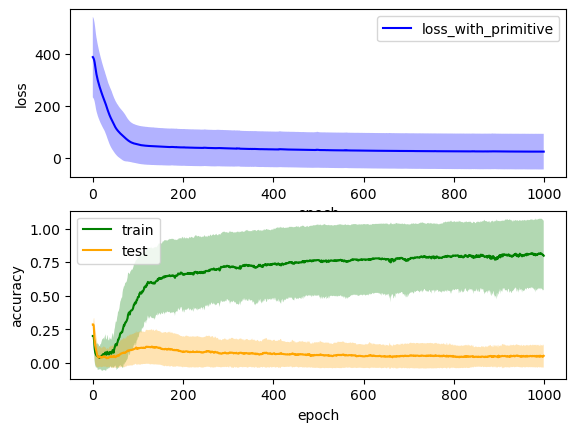

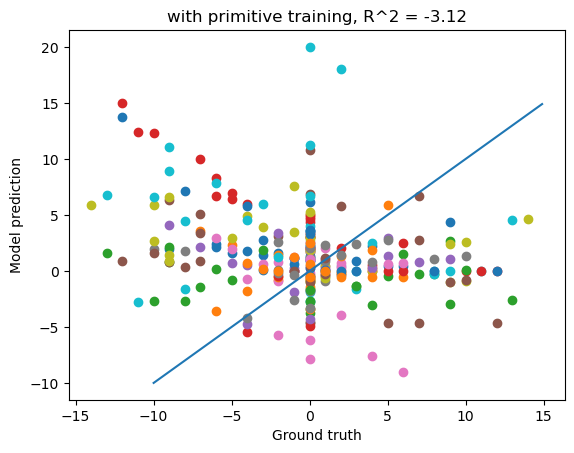

In [97]:
# 0ne of each other
trainseqs =generate_self(ops, ['A'])+ generate_trials(ops, ['C'], ['B']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

# 3 trials

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8]]
run time:  17.131321048736574
47
total time:  17.14127291838328
47 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.0 
-----------



label      pred  acc
trial                                        
['A', '-', 'B', '=']  1.255319  0.551690  0.0
['A', '-', 'C', '='] -0.191489  0.584787  0.0
['B', '-', 'A', '='] -1.255319  1.100853  0.0
['B', '-', 'C', '='] -1.446809  1.145738  0.0
['C', '-', 'A', '=']  0.191489  0.805190  0.0
['C', '-', 'B', '=']  1.446809  0.801604  0.0

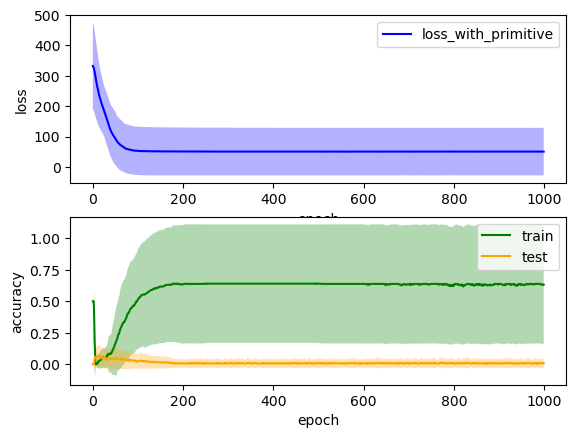

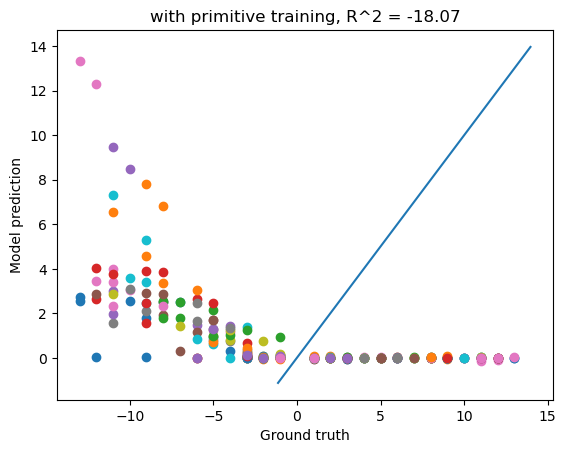

In [57]:
# 3 self
trainseqs =generate_self(ops, all_syms)[:3] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.126095827420553
30
total time:  4.130174314975738
30 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.03 
-----------



label      pred       acc
trial                                             
['A', '-', 'A', '=']  0.000000 -0.522588  0.066667
['B', '-', 'B', '=']  0.000000  0.630792  0.066667
['A', '-', 'C', '='] -0.233333 -0.283380  0.033333
['C', '-', 'C', '=']  0.000000 -0.086342  0.033333
['B', '-', 'A', '=']  0.266667  0.607574  0.000000
['C', '-', 'B', '='] -0.033333  0.847649  0.000000

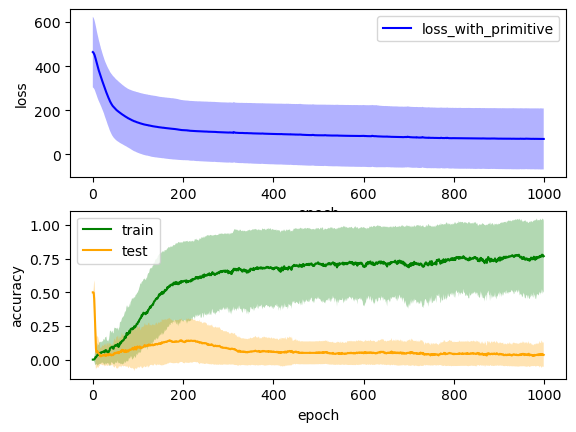

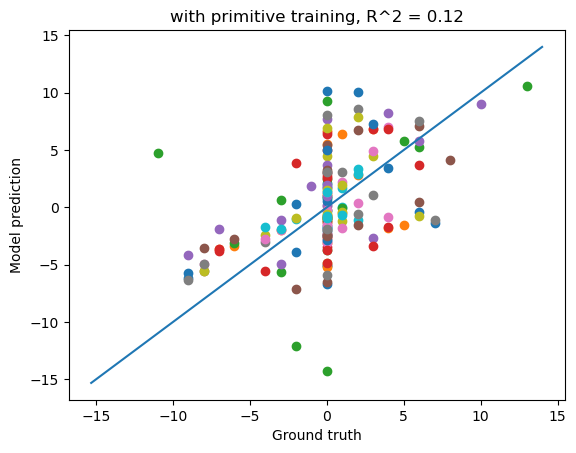

In [56]:
# 3 other
trainseqs =generate_other(ops, all_syms)[:3] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.234399183591207
32
total time:  4.239163716634114
32 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.1 
-----------



label      pred      acc
trial                                           
['C', '-', 'B', '=']  0.90625  4.557933  0.18750
['C', '-', 'C', '=']  0.00000  2.274537  0.15625
['B', '-', 'B', '=']  0.00000  2.394558  0.12500
['C', '-', 'A', '='] -1.84375  3.131360  0.06250
['B', '-', 'A', '='] -2.75000  3.686467  0.03125
['B', '-', 'C', '='] -0.90625  4.669383  0.03125

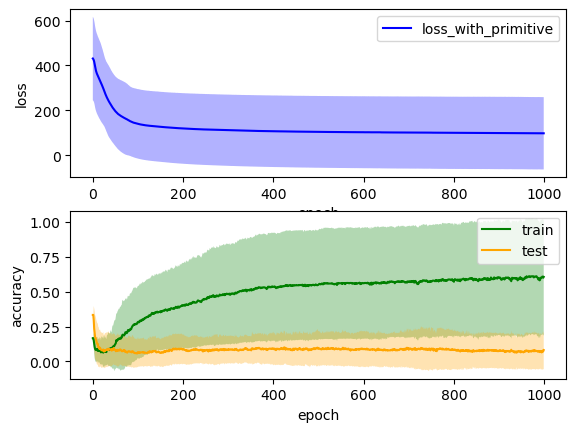

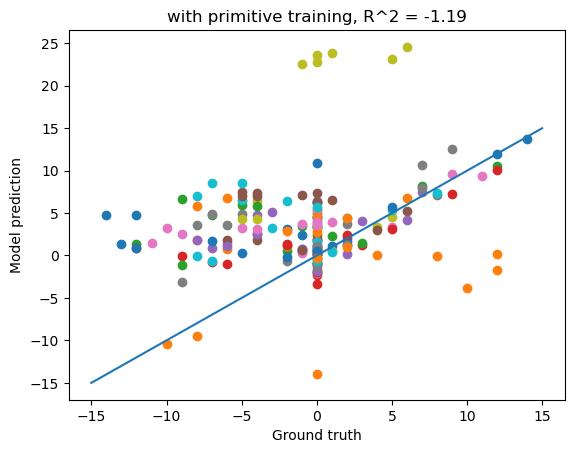

In [66]:
# row : A + _
trainseqs =generate_trials(ops, all_syms, ['A']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.210112500190735
23
total time:  4.213260213534038
23 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.02 
-----------



label      pred       acc
trial                                             
['A', '-', 'B', '=']  0.782609  0.255415  0.043478
['B', '-', 'B', '=']  0.000000 -0.536213  0.043478
['C', '-', 'B', '=']  0.478261  0.003864  0.043478
['A', '-', 'C', '=']  0.304348  0.602595  0.000000
['B', '-', 'C', '='] -0.478261 -0.247225  0.000000
['C', '-', 'C', '=']  0.000000  0.228483  0.000000

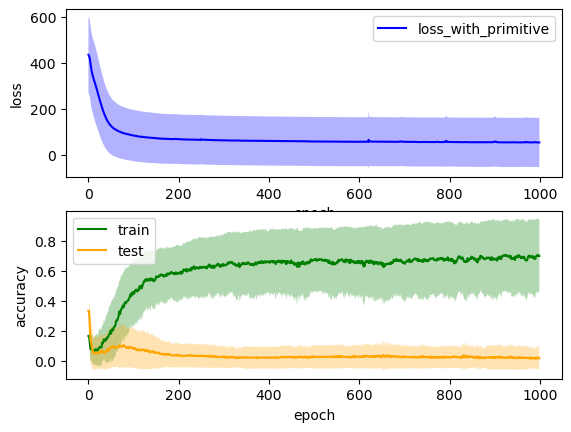

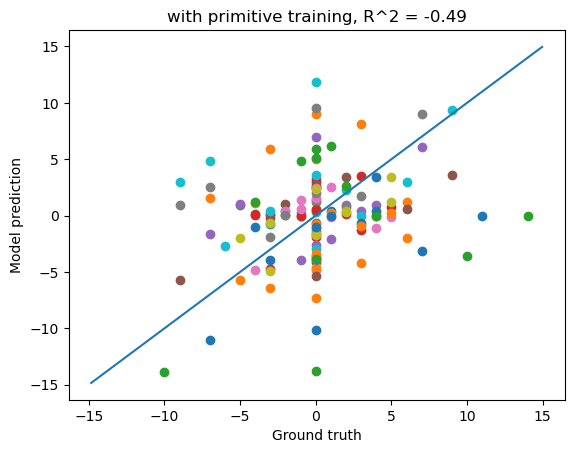

In [68]:
# column : _ + A
trainseqs = generate_trials(ops, ['A'], all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'C'), '=', 0]]
run time:  3.1135085145632426
54
total time:  3.1198649644851684
54 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.06 
-----------



label      pred       acc
trial                                             
['B', '-', 'A', '=']  0.333333 -0.065572  0.111111
['A', '-', 'B', '='] -0.333333  0.253012  0.074074
['A', '-', 'C', '='] -0.648148 -0.314584  0.055556
['B', '-', 'B', '=']  0.000000  0.247186  0.037037
['C', '-', 'A', '=']  0.648148  0.139824  0.037037
['C', '-', 'C', '=']  0.000000 -0.276153  0.018519

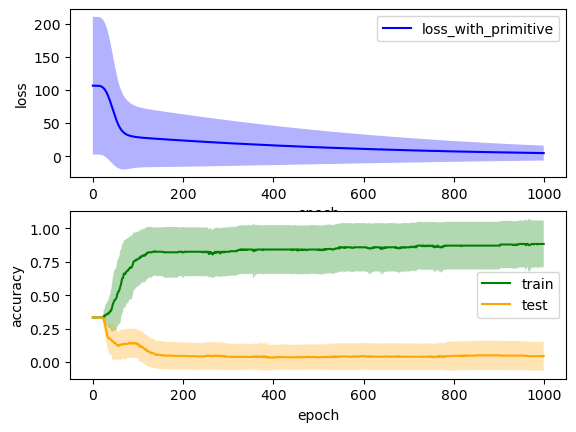

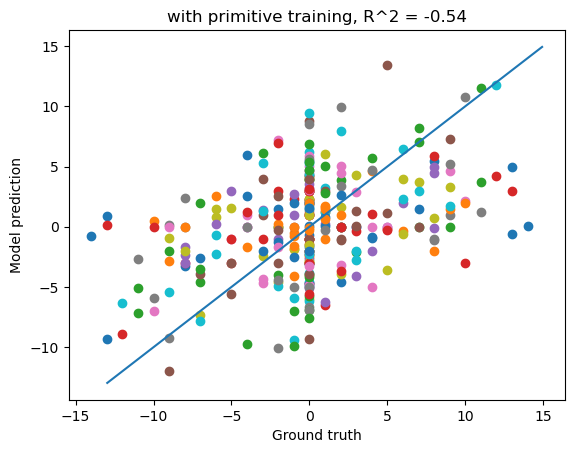

In [100]:
# 1 self, 2 other
trainseqs = generate_self(ops, ['A']) +  generate_other(ops, ['B', 'C'])
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'A'), '=', -1], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  5.870519065856934
32
total time:  5.878616281350454
32 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.12 
-----------



label      pred      acc
trial                                          
['C', '-', 'C', '=']  0.0000  1.414984  0.37500
['A', '-', 'B', '='] -3.0625  2.397837  0.15625
['C', '-', 'A', '=']  0.7500  2.470340  0.12500
['C', '-', 'B', '='] -2.3125  2.374793  0.06250
['A', '-', 'C', '='] -0.7500  1.335367  0.00000
['B', '-', 'C', '=']  2.3125  1.915970  0.00000

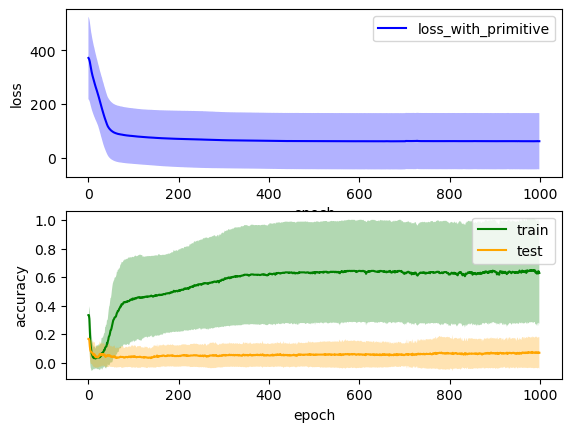

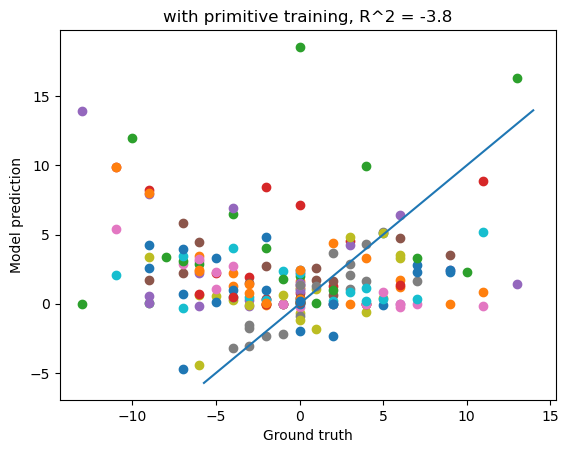

In [102]:
# 2 self, 1 other
trainseqs = generate_self(ops, ['A', 'B']) +  generate_trials(ops, ['A'], ['B']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  20.132211033503214
42
total time:  20.137542128562927
42 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.03 
-----------



label      pred       acc
trial                                             
['C', '-', 'C', '=']  0.000000  1.851577  0.095238
['C', '-', 'B', '=']  0.857143  1.643060  0.047619
['B', '-', 'C', '='] -0.857143  0.732300  0.023810
['A', '-', 'B', '='] -0.809524  1.216459  0.000000
['A', '-', 'C', '='] -1.666667  1.117953  0.000000
['B', '-', 'A', '=']  0.809524  0.344885  0.000000

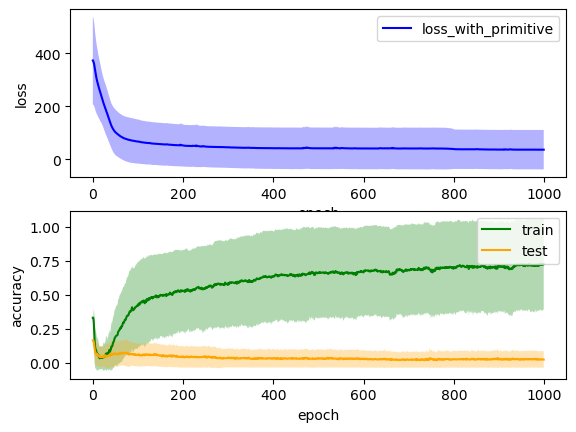

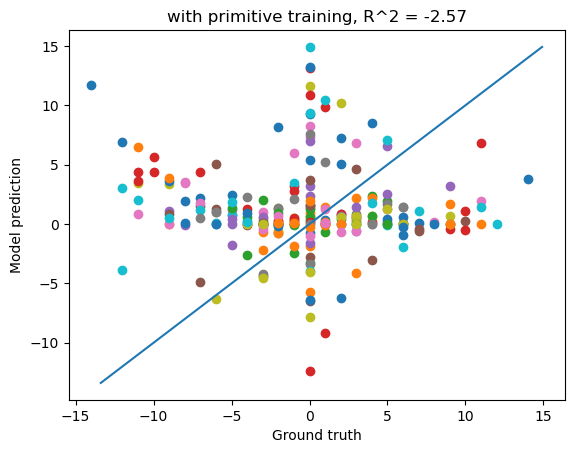

In [104]:
# 2 self, 1 other
trainseqs = generate_self(ops, ['A', 'B']) +  generate_trials(ops, ['A'], ['C']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'C'), '=', 0]]
run time:  4.1202186663945515
47
total time:  4.127264416217804
47 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.07 
-----------



label      pred       acc
trial                                             
['B', '-', 'B', '=']  0.000000  0.002823  0.212766
['C', '-', 'C', '=']  0.000000 -0.148812  0.148936
['A', '-', 'B', '='] -1.425532  0.958450  0.021277
['A', '-', 'C', '='] -1.319149  1.161820  0.021277
['B', '-', 'A', '=']  1.425532  0.149249  0.021277
['C', '-', 'A', '=']  1.319149  0.080492  0.021277

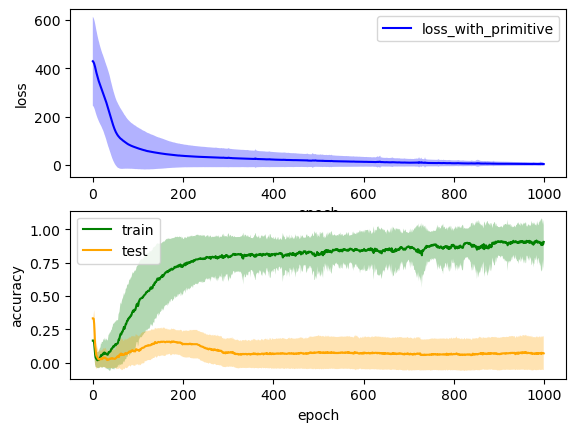

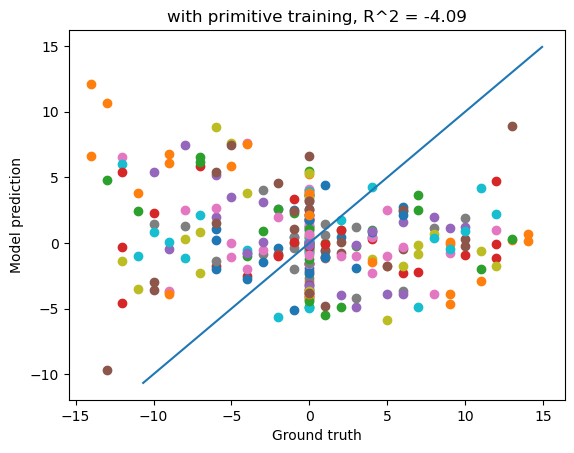

In [105]:
# 2 self, 1 other
trainseqs = generate_self(ops, ['A']) +  generate_trials(ops, ['C'], ['B'])+\
            generate_trials(ops, ['B'], ['C'])+ p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['B', ('-', 'A'), '=', -1], ['A', ('-', 'A'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.2520403663317365
37
total time:  4.257820832729339
37 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.13 
-----------



label      pred       acc
trial                                             
['B', '-', 'B', '=']  0.000000 -0.826731  0.297297
['C', '-', 'C', '=']  0.000000 -0.182783  0.216216
['C', '-', 'B', '='] -2.648649  1.749776  0.135135
['B', '-', 'C', '=']  2.648649 -0.994367  0.081081
['A', '-', 'C', '=']  3.702703  0.416200  0.027027
['C', '-', 'A', '='] -3.702703  0.746172  0.027027

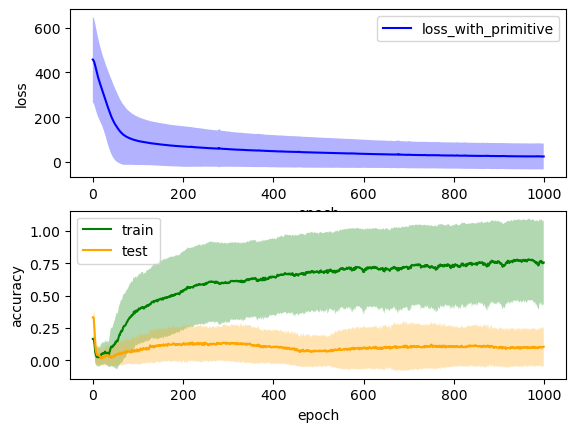

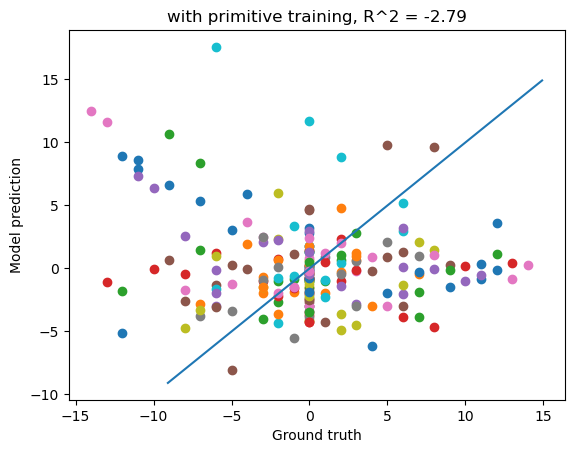

In [109]:
# 3 self, 1 other
trainseqs =generate_other(ops, ['A', 'B']) + generate_self(ops, ['A']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8]]
run time:  4.55609069665273
41
total time:  4.56060498158137
41 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.05 
-----------



label      pred       acc
trial                                             
['B', '-', 'A', '='] -3.414634  1.947792  0.121951
['C', '-', 'B', '=']  0.073171  1.671883  0.073171
['A', '-', 'C', '=']  3.341463  1.476624  0.048780
['B', '-', 'C', '='] -0.073171  1.034403  0.024390
['C', '-', 'A', '='] -3.341463  2.153784  0.000000

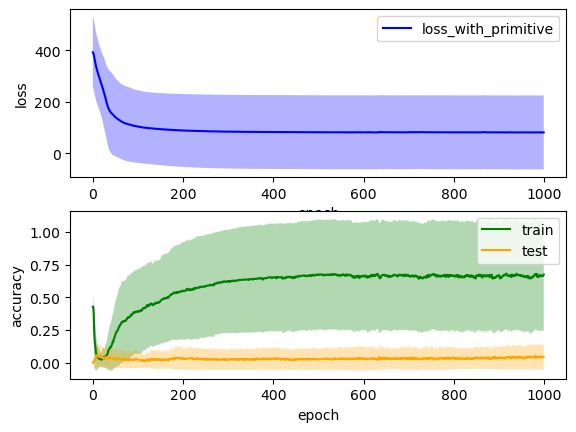

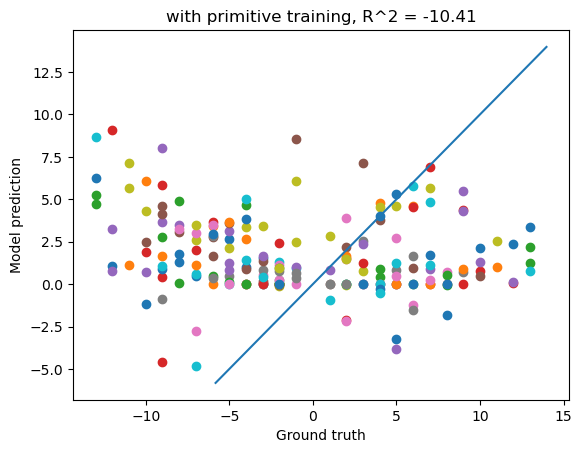

In [69]:
# 3 self, 1 other
trainseqs =[generate_other(ops, all_syms)[0]] + generate_self(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.864115266005198
32
total time:  4.867551183700561
32 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.17 
-----------



label      pred      acc
trial                                         
['C', '-', 'B', '=']  1.000  0.981605  0.40625
['C', '-', 'C', '=']  0.000  0.129168  0.15625
['A', '-', 'C', '='] -0.625 -0.013159  0.09375
['B', '-', 'A', '='] -0.375  0.157455  0.09375
['B', '-', 'B', '=']  0.000 -0.817534  0.09375

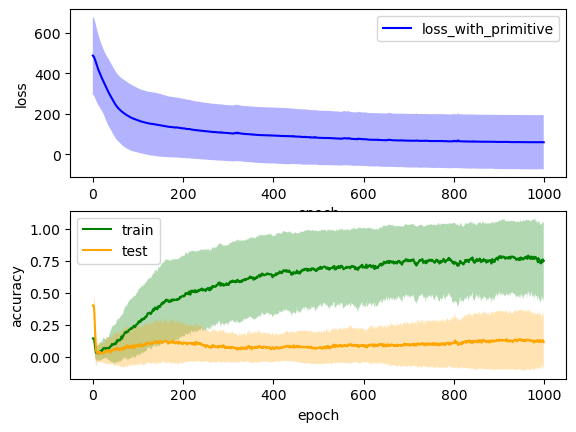

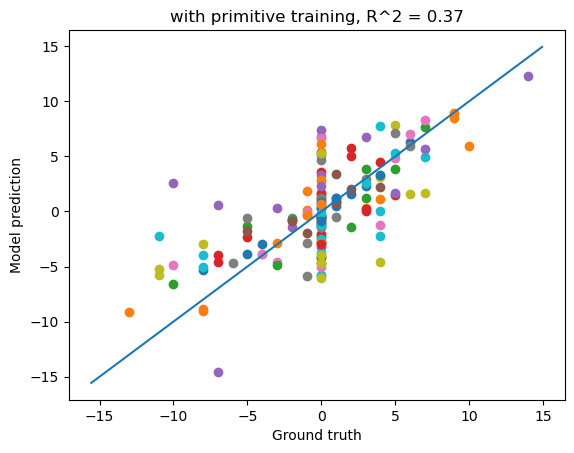

In [70]:
# 1 self, 3 other
trainseqs =[generate_self(ops, all_syms)[0]] + generate_other(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['B', ('-', 'B'), '=', 0], ['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.6051839391390486
43
total time:  4.610520668824514
43 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.29 
-----------



label      pred       acc
trial                                             
['B', '-', 'C', '=']  0.255814  3.150690  0.418605
['C', '-', 'C', '=']  0.000000  1.709090  0.372093
['B', '-', 'A', '='] -1.441860  2.459405  0.325581
['C', '-', 'B', '='] -0.255814  3.856750  0.186047
['C', '-', 'A', '='] -1.697674  2.989121  0.139535

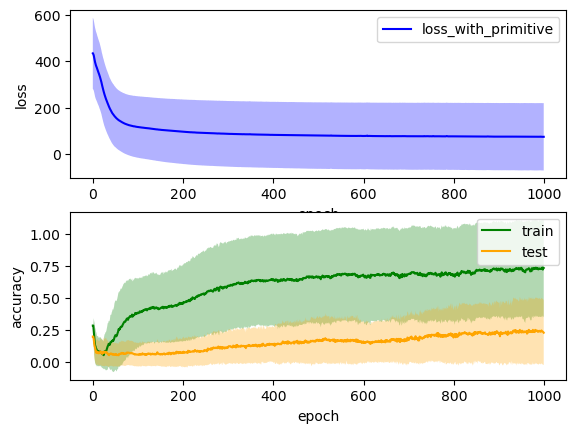

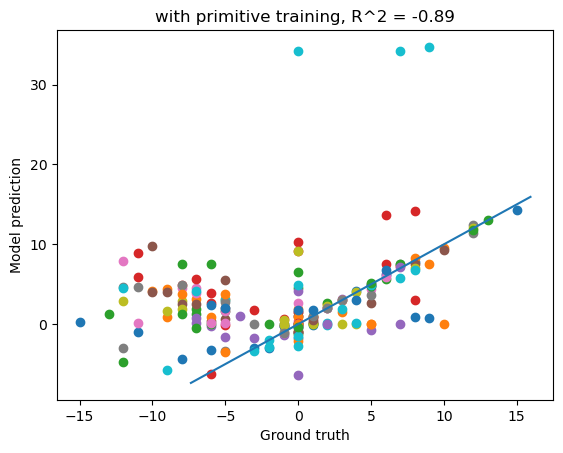

In [75]:
# 2 self, 2 other
trainseqs = [generate_self(ops, all_syms)[1]] + generate_trials(ops, all_syms, ['A']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.7477879842122395
36
total time:  4.750999029477438
36 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.03 
-----------



label      pred       acc
trial                                             
['A', '-', 'B', '='] -2.305556  1.336359  0.055556
['A', '-', 'C', '='] -2.111111  1.050821  0.027778
['B', '-', 'A', '=']  2.305556  0.667117  0.027778
['C', '-', 'B', '='] -0.194444  2.437742  0.027778
['C', '-', 'C', '=']  0.000000  1.639297  0.027778

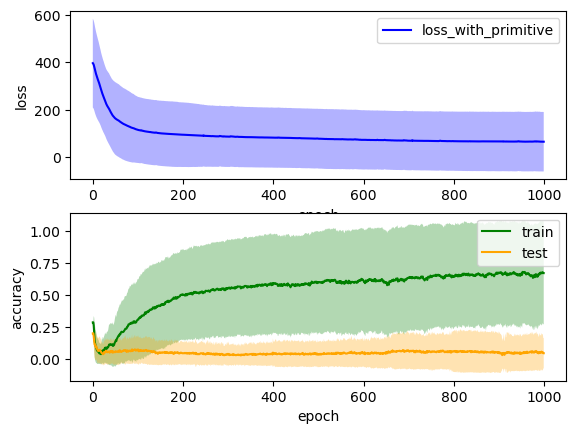

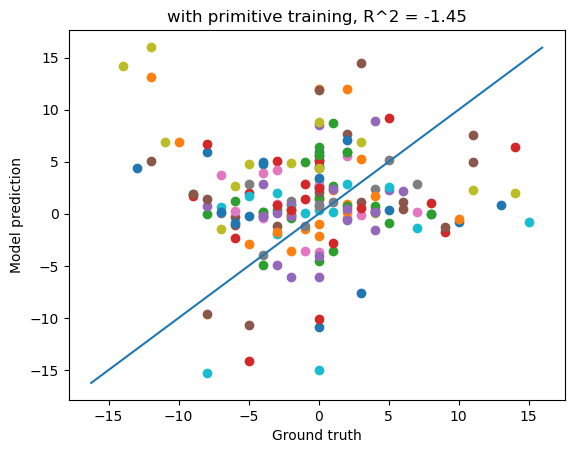

In [76]:
# 2 self, 2 other
trainseqs = generate_self(ops, all_syms)[:2] + generate_other(ops, all_syms)[1:] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.739388751983642
31
total time:  4.744667184352875
31 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.24 
-----------



label      pred       acc
trial                                             
['A', '-', 'B', '='] -3.290323  2.244088  0.354839
['C', '-', 'B', '='] -1.870968  0.158408  0.354839
['C', '-', 'C', '=']  0.000000  0.826137  0.258065
['B', '-', 'C', '=']  1.870968  2.249308  0.161290
['A', '-', 'C', '='] -1.419355  1.293411  0.064516

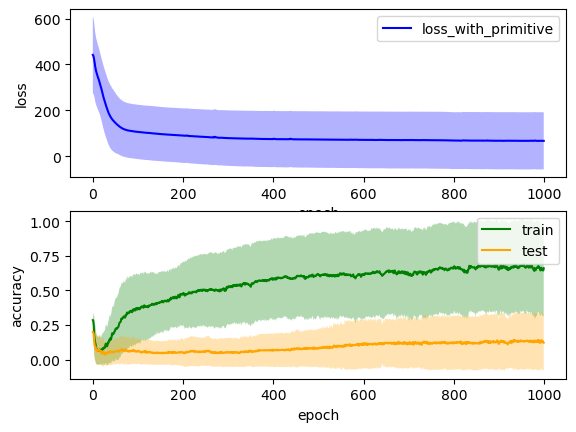

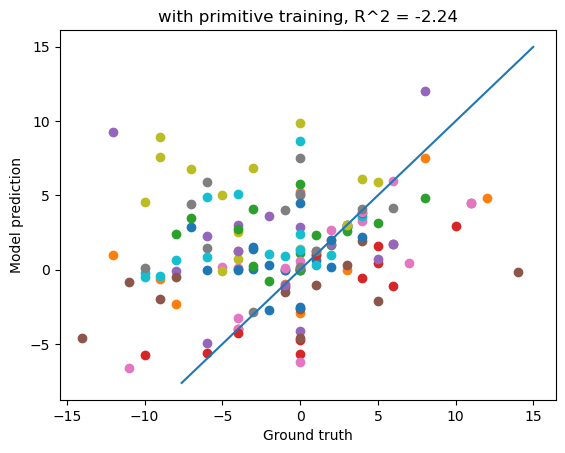

In [89]:
# 2 self, 2 other
trainseqs = generate_self(ops, all_syms)[:2] + generate_trials(ops, ['A'],['B','C']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'A'), '=', -9], ['A', ('-', 'B'), '=', 1], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.42480773528417
23
total time:  4.427767586708069
23 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.23 
-----------



label      pred       acc
trial                                             
['B', '-', 'B', '=']  0.000000  0.489070  0.478261
['C', '-', 'B', '='] -0.739130  0.277847  0.260870
['A', '-', 'C', '='] -0.130435  0.074257  0.173913
['C', '-', 'C', '=']  0.000000  0.068907  0.130435
['B', '-', 'C', '=']  0.739130  0.969902  0.086957

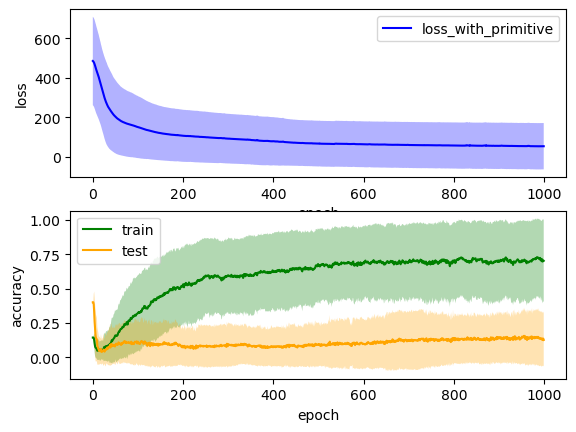

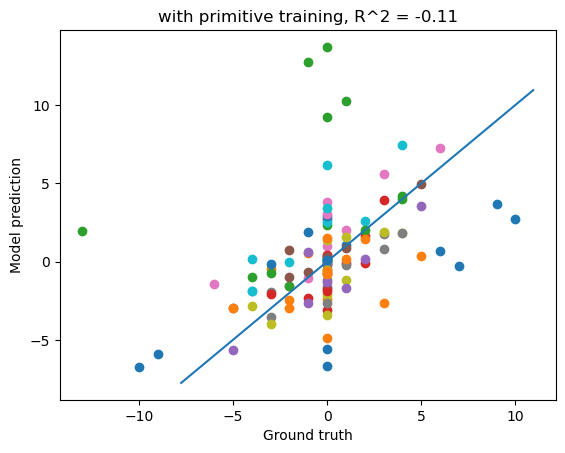

In [107]:
# 3 self, 2 other
trainseqs = generate_trials(ops, ['A'], all_syms) + generate_trials(ops, ['B'], ['A']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

## 5 trials

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'B'), '=', -8]]
run time:  5.0915381669998165
32
total time:  5.094709980487823
32 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.16 
-----------



label      pred      acc
trial                                          
['B', '-', 'A', '=']  2.8125  1.127229  0.28125
['A', '-', 'B', '='] -2.8125  1.712387  0.12500
['A', '-', 'C', '='] -0.2500  3.029701  0.12500
['C', '-', 'B', '='] -2.5625 -0.064887  0.12500

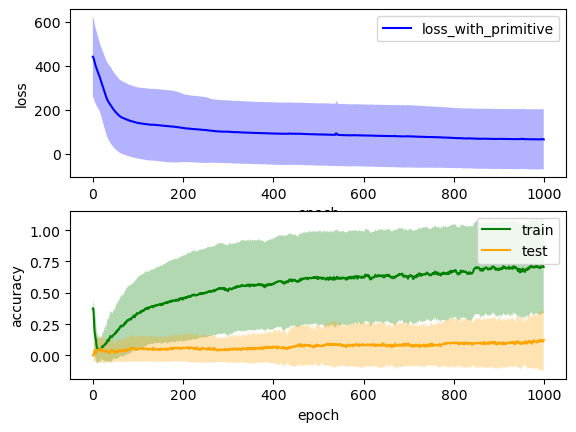

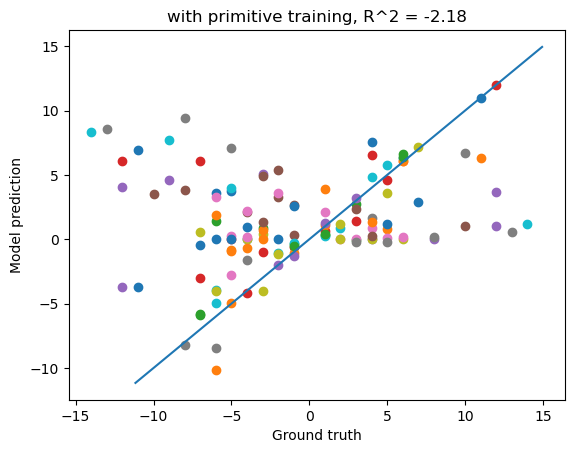

In [77]:
# 3 self, 2 other
trainseqs = generate_self(ops, all_syms) + generate_other(ops, all_syms)[1:] + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0], ['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['B', ('-', 'A'), '=', -1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8]]
run time:  4.906436467170716
46
total time:  4.911107850074768
46 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.24 
-----------



label      pred       acc
trial                                             
['C', '-', 'B', '='] -0.195652  2.799823  0.282609
['B', '-', 'C', '=']  0.195652  2.690163  0.260870
['B', '-', 'A', '='] -2.434783  2.020591  0.217391
['C', '-', 'A', '='] -2.630435  2.868068  0.195652

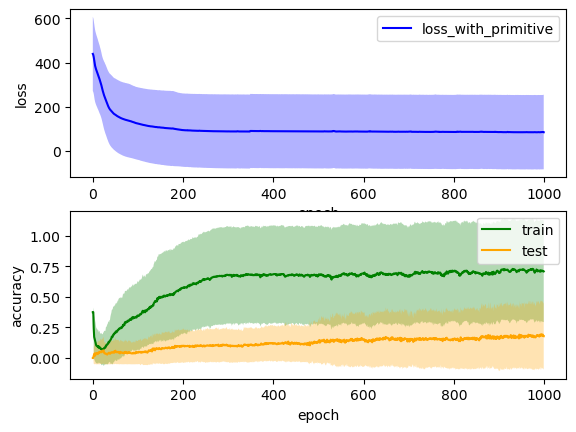

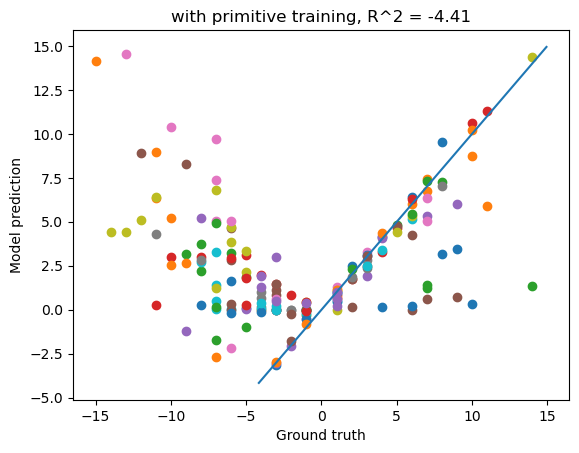

In [80]:
# 3 self, 2 other
trainseqs = generate_self(ops, all_syms)[1:] + generate_trials(ops, all_syms, ['A']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['A', ('-', 'B'), '=', 1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.965496945381164
38
total time:  4.973437333106995
38 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.36 
-----------



label      pred       acc
trial                                             
['B', '-', 'A', '='] -1.657895 -0.954800  0.473684
['C', '-', 'B', '='] -0.105263 -0.253930  0.368421
['A', '-', 'C', '=']  1.763158  1.410659  0.342105
['C', '-', 'C', '=']  0.000000 -1.079107  0.263158

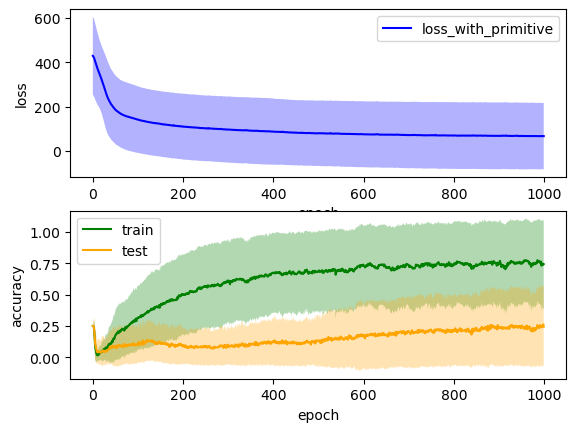

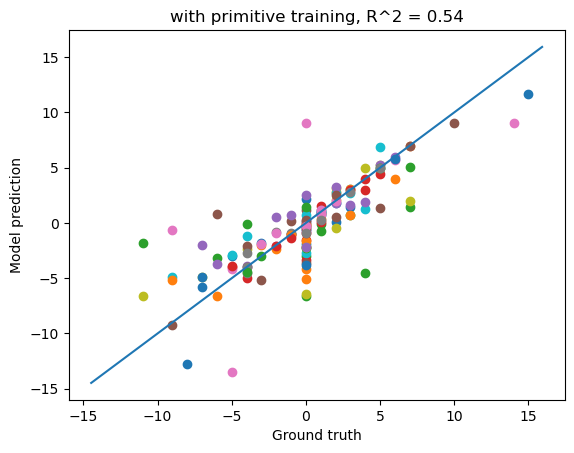

In [79]:
# 2 self, 3 other
trainseqs = generate_self(ops, all_syms)[:2] + generate_other(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['B', ('-', 'A'), '=', -1], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  5.079774034023285
25
total time:  5.082527554035186
25 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.28 
-----------



label      pred   acc
trial                                      
['B', '-', 'A', '=']  -1.48  0.904301  0.40
['C', '-', 'B', '=']  -1.20  2.098119  0.28
['C', '-', 'C', '=']   0.00  2.727790  0.28
['C', '-', 'A', '=']  -2.68  3.318682  0.16

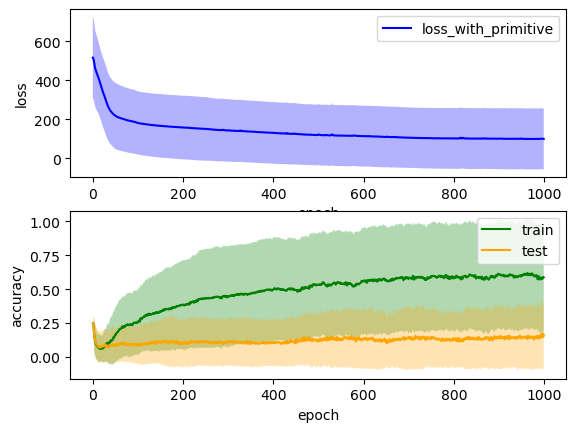

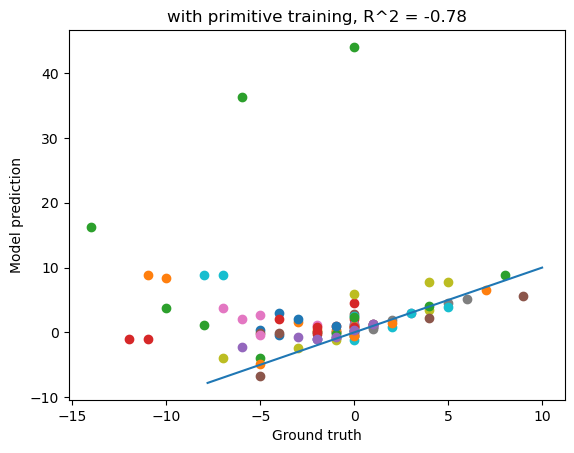

In [78]:
# 2 self, 3 other
trainseqs = generate_trials(ops, all_syms, ['A']) + generate_trials(ops, ['B','C'], ['B'])  + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['B', ('-', 'B'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  5.071274296442668
41
total time:  5.07663247982661
41 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.38 
-----------



label      pred       acc
trial                                             
['B', '-', 'C', '=']  2.073171  2.096129  0.609756
['C', '-', 'C', '=']  0.000000 -0.344421  0.341463
['C', '-', 'A', '='] -0.390244  1.950060  0.317073
['C', '-', 'B', '='] -2.073171  1.237192  0.243902

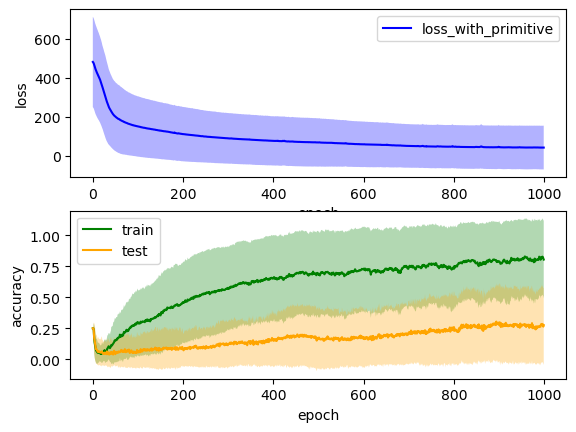

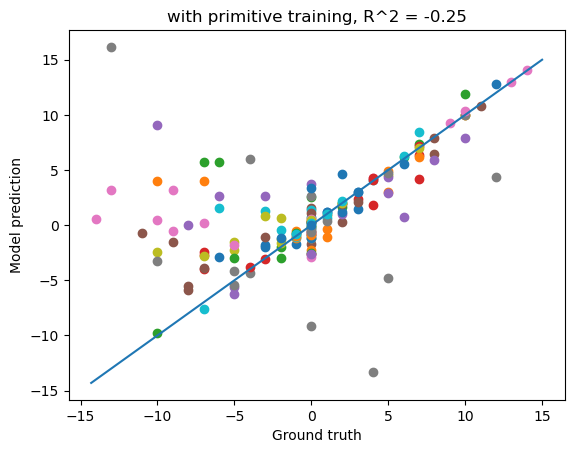

In [81]:
# 2 self, 3 other
trainseqs = generate_trials(ops, all_syms, ['A']) + generate_trials(ops, ['A','B'], ['B'])  + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.850532766183218
35
total time:  4.8537265181541445
35 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.41 
-----------



label      pred       acc
trial                                             
['B', '-', 'A', '='] -1.085714 -0.165668  0.542857
['A', '-', 'C', '=']  1.085714  1.241534  0.485714
['C', '-', 'B', '=']  0.000000 -0.244656  0.314286
['C', '-', 'C', '=']  0.000000 -1.306104  0.285714

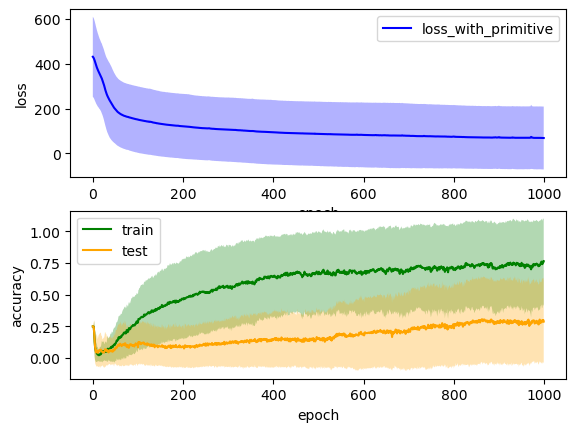

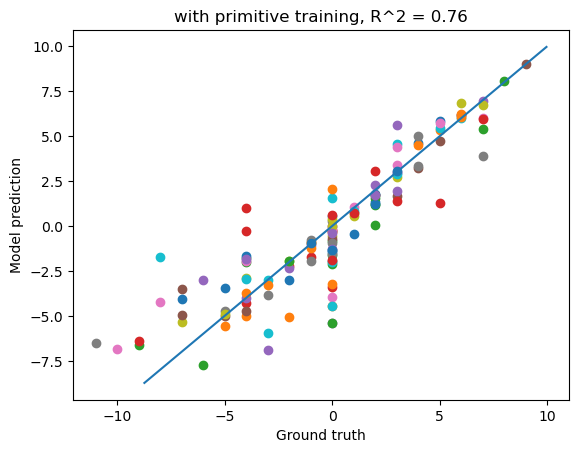

In [82]:
# 2 self, 3 other
trainseqs = generate_other(ops, all_syms) + generate_self(ops, all_syms)[:2]  + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'A'), '=', 0], ['A', ('-', 'B'), '=', 1], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['C', ('-', 'A'), '=', -9], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['B', ('-', 'B'), '=', 0], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  4.915096517403921
43
total time:  4.918893551826477
43 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.45 
-----------



label      pred       acc
trial                                             
['B', '-', 'B', '=']  0.000000 -0.247418  0.534884
['C', '-', 'B', '='] -0.372093  0.255372  0.441860
['B', '-', 'C', '=']  0.372093  0.964533  0.418605
['C', '-', 'C', '=']  0.000000 -0.726455  0.395349

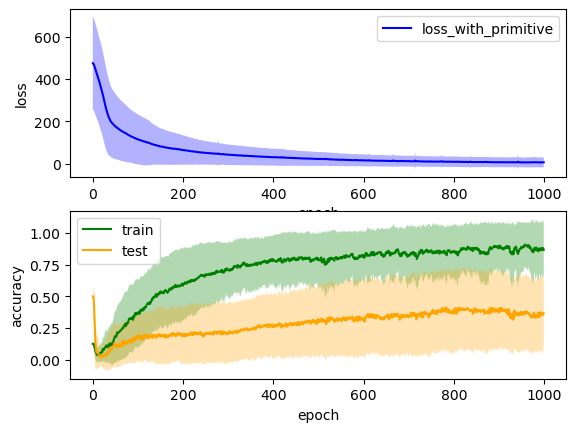

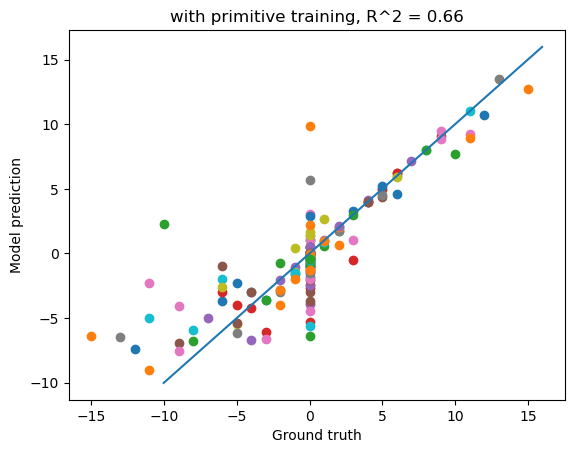

In [84]:
# 2 self, 3 other
trainseqs = generate_trials(ops, all_syms, ['A']) + generate_trials(ops, ['A'], ['B', 'C'])  + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 1], ['B', ('-', 'C'), '=', 8], ['C', ('-', 'A'), '=', -9], ['A', ('-', 'C'), '=', 9], ['B', ('-', 'A'), '=', -1], ['A', '=', 4], ['B', '=', 7], ['C', '=', 12]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'B'), '=', -8], ['C', ('-', 'C'), '=', 0]]
run time:  5.212920765082042
27
total time:  5.215722997983296
27 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.5 
-----------



label      pred       acc
trial                                            
['C', '-', 'C', '=']  0.00000 -0.491132  0.592593
['A', '-', 'A', '=']  0.00000 -0.751153  0.518519
['B', '-', 'B', '=']  0.00000 -0.114209  0.481481
['C', '-', 'B', '='] -0.37037  0.560959  0.407407

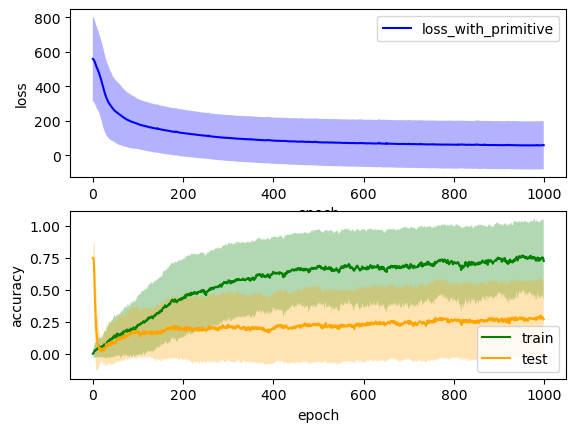

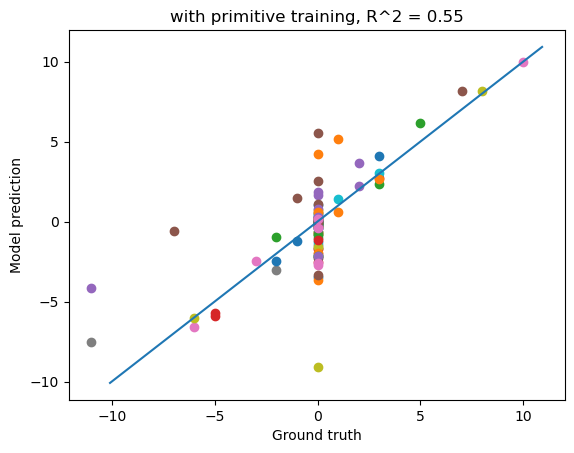

In [87]:
# 5 other
trainseqs = generate_other(ops, all_syms) + generate_trials(ops, ['C'], ['A'])\
            + generate_trials(ops, ['A'], ['B']) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 6], ['B', ('-', 'C'), '=', -2], ['C', ('-', 'A'), '=', -4], ['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0], ['A', '=', 14], ['B', '=', 8], ['C', '=', 10]]
testseqs:  [['A', ('-', 'C'), '=', 4], ['B', ('-', 'A'), '=', -6], ['C', ('-', 'B'), '=', 2]]
run time:  12.801224517822266
69
total time:  12.80709929863612
69 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.68 
-----------



label      pred       acc
trial                                             
['A', '-', 'C', '='] -0.362319  0.380436  0.695652
['B', '-', 'A', '='] -0.260870  0.458340  0.681159
['C', '-', 'B', '=']  0.623188  1.301871  0.652174

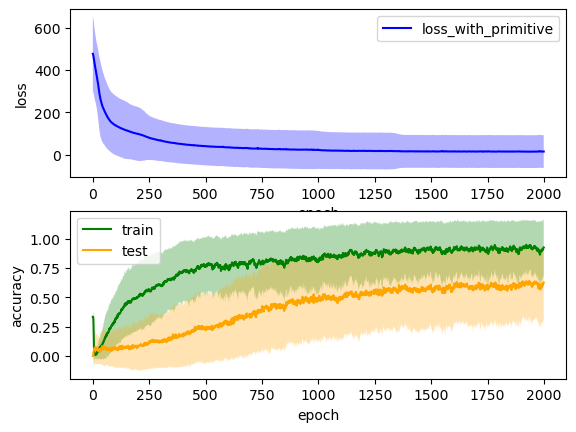

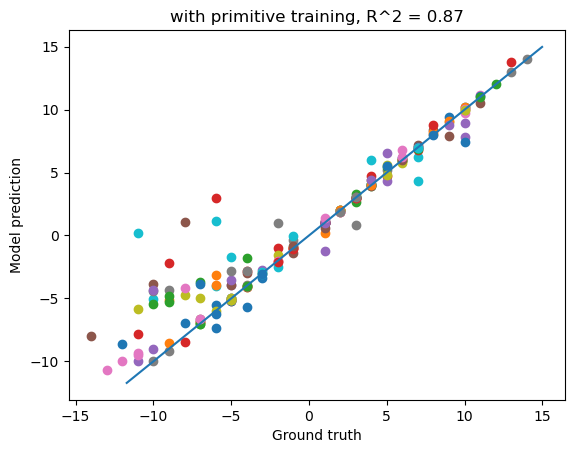

In [24]:
# 3
# all other + self

trainseqs = generate_other(ops, all_syms) + generate_self(ops, all_syms) + p
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 6], ['B', ('-', 'C'), '=', -2], ['C', ('-', 'A'), '=', -4], ['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0]]
testseqs:  [['A', ('-', 'C'), '=', 4], ['B', ('-', 'A'), '=', -6], ['C', ('-', 'B'), '=', 2]]
run time:  7.860321466128031
43
total time:  7.8646573980649315
43 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.41 
-----------



label      pred       acc
trial                                             
['B', '-', 'A', '=']  0.209302 -0.157032  0.465116
['C', '-', 'B', '=']  1.209302  0.479236  0.395349
['A', '-', 'C', '='] -1.418605 -1.328638  0.372093

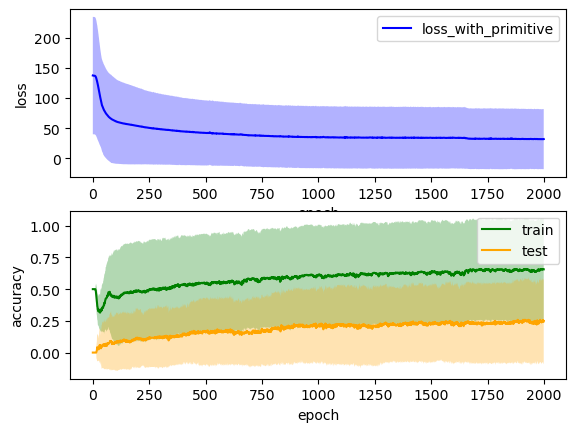

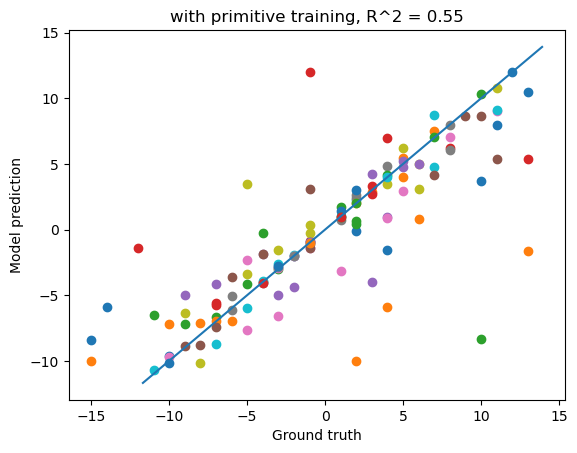

In [29]:
# 3
# all other + self + no primitives

trainseqs = generate_other(ops, all_syms) + generate_self(ops, all_syms)
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 6], ['B', ('-', 'C'), '=', -2], ['C', ('-', 'A'), '=', -4], ['A', ('-', 'C'), '=', 4], ['B', ('-', 'A'), '=', -6], ['C', ('-', 'B'), '=', 2]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0]]
run time:  9.115541299184164
27
total time:  9.118909966945647
27 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.38 
-----------



label      pred       acc
trial                                          
['A', '-', 'A', '=']    0.0  0.754694  0.518519
['B', '-', 'B', '=']    0.0  0.168924  0.333333
['C', '-', 'C', '=']    0.0 -0.017569  0.296296

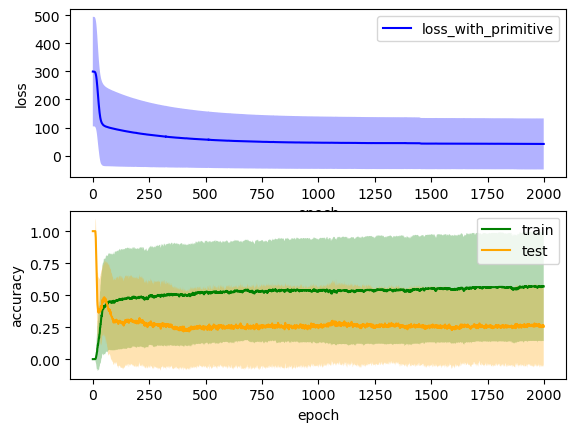

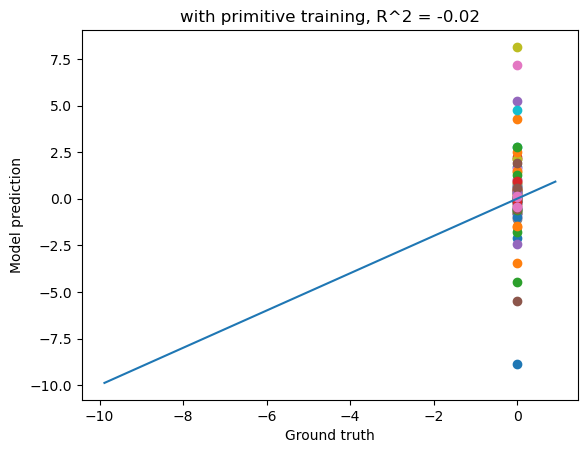

In [31]:
# 4
# all other + alternative other 

trainseqs = generate_other(ops, all_syms) + generate_other_reverse(ops, all_syms) 
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']

trainseqs:  [['A', ('-', 'B'), '=', 6], ['B', ('-', 'C'), '=', -2], ['C', ('-', 'A'), '=', -4], ['A', ('-', 'C'), '=', 4], ['B', ('-', 'A'), '=', -6], ['C', ('-', 'B'), '=', 2]]
testseqs:  [['A', ('-', 'A'), '=', 0], ['B', ('-', 'B'), '=', 0], ['C', ('-', 'C'), '=', 0]]
run time:  9.745189515749614
37
total time:  9.749512430032095
37 / 80  rnns trained to 100% accuracy.        
 Mean test acc =  0.44 
-----------



label      pred       acc
trial                                          
['B', '-', 'B', '=']    0.0  0.433644  0.594595
['A', '-', 'A', '=']    0.0 -0.184622  0.378378
['C', '-', 'C', '=']    0.0  0.394322  0.351351

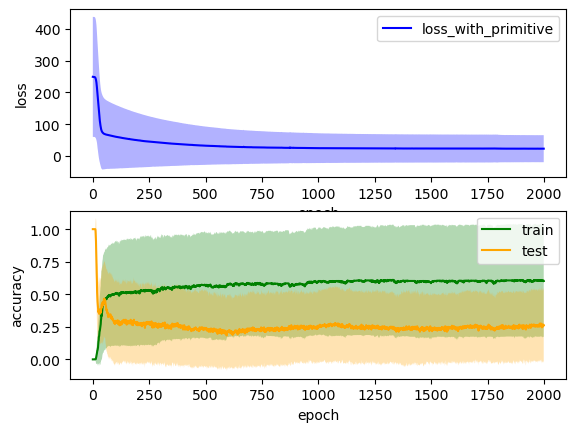

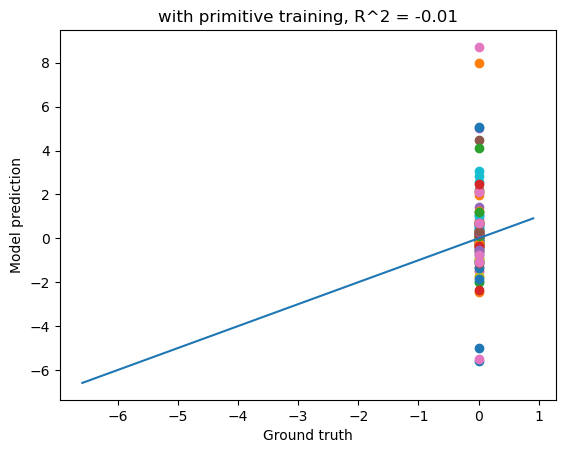

In [32]:
# 4
# all other + alternative other + primitives

trainseqs = generate_other(ops, all_syms) + generate_other_reverse(ops, all_syms) 
testseqs = generate_trials(ops, all_syms, all_syms)
testseqs = [s for s in testseqs if s not in trainseqs]
print('trainseqs: ', trainseqs)
print('testseqs: ', testseqs)
res = run_plot(trainseqs, testseqs, cue_dict)
res['df_trials']